# Tutorial 6: Integrate horizontal slices with MaskGraphene

In [2]:
import logging
import numpy as np
from tqdm import tqdm
import torch
import pickle
import sys
import os
import scanpy as sc
import sklearn.metrics.pairwise

# Get the parent directory of the current script
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the system path
sys.path.insert(0, parent_dir)

from utils import (
    build_args_ST,
    create_optimizer
)
from datasets.st_loading_utils import visualization_umap_spatial, create_dictionary_mnn
from models import build_model_ST

In [3]:
args = build_args_ST()

args.section_ids=["MA","MP"]
num_hidden = [512,32]
lr = 0.0003
args.max_epoch = 3000
args.max_epoch_triplet = 500
args.dataset_name = "MB2SAP"
args.num_hidden = num_hidden
args.num_layers = len(num_hidden)

args.alpha_l = 1
args.lam = 1
args.loss_fn = "sce"
args.mask_rate = 0.1
args.in_drop = 0
args.attn_drop = 0
args.remask_rate = 0.1
args.seeds = [2024]
# args.num_remasking = 3
args.hvgs = 5000
args.lr = lr
args.activation = "prelu"
args.negative_slope = 0.2
# args.num_dec_layers = 1

#### remember to change these paths to your data path/link path
args.st_data_dir="../../spatial_benchmarking/benchmarking_data/mMAMP"
args.hl_dir="../hard_links/MB2SAP"

In [4]:
import dgl
import scipy
import anndata
from datasets.data_proc import load_ST_dataset

dataset_name = args.dataset_name
section_ids = args.section_ids

print(dataset_name)
graph, (num_features, num_cls), ad_concat = load_ST_dataset(dataset_name=dataset_name, section_ids=section_ids, args_=args)
args.num_features = num_features
args.num_class = num_cls
x = graph.ndata["feat"]

MB2SAP


/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...


/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/data_proc.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/data_proc.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
/home/huy21/anaconda3/envs/MaskGraphene/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make t

The graph contains 15686 edges, 2696 cells.
5.8182 neighbors per cell on average.
no gt available
------Calculating spatial graph...


/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/data_proc.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/data_proc.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)


The graph contains 19592 edges, 3353 cells.
5.8431 neighbors per cell on average.


In [5]:
model = build_model_ST(args)
print(model)

device = args.device if args.device >= 0 else "cpu"
model.to(device)

optim_type = args.optimizer 
lr = args.lr
weight_decay = args.weight_decay
optimizer = create_optimizer(optim_type, model, lr, weight_decay)

use_scheduler = args.scheduler
max_epoch = args.max_epoch
max_epoch_triplet = args.max_epoch_triplet
if use_scheduler:
    logging.critical("Use scheduler")
    scheduler = lambda epoch :( 1 + np.cos((epoch) * np.pi / max_epoch) ) * 0.5
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler)
else:
    scheduler = None

=== Use sce_loss and alpha_l=1 ===
num_encoder_params: 1575521, num_decoder_params: 1584551, num_params_in_total: 3198540
PreModel(
  (encoder): GAT(
    (gat_layers): ModuleList(
      (0): GATConv(
        (fc): Linear(in_features=3042, out_features=512, bias=False)
        (feat_drop): Dropout(p=0, inplace=False)
        (attn_drop): Dropout(p=0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (activation): PReLU(num_parameters=1)
      )
      (1): GATConv(
        (fc): Linear(in_features=512, out_features=32, bias=False)
        (feat_drop): Dropout(p=0, inplace=False)
        (attn_drop): Dropout(p=0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
      )
    )
    (head): Identity()
  )
  (decoder): GAT(
    (gat_layers): ModuleList(
      (0): GATConv(
        (fc): Linear(in_features=32, out_features=512, bias=False)
        (feat_drop): Dropout(p=0, inplace=False)
        (attn_drop): Dropout(p=0, inplace=False)
        (leaky_r

In [6]:
from maskgraphene_main import MG, MG_triplet

model, ad_concat_1 = MG(model, graph, x, optimizer, max_epoch, device, ad_concat, scheduler, logger=None, key_="MG")
model, ad_concat_2 = MG_triplet(model, graph, x, optimizer, max_epoch_triplet, device, adata_concat_=ad_concat_1, scheduler=scheduler, logger=None, key_="MG_triplet")

CRITICAL:root:start training..
100%|██████████| 3000/3000 [02:08<00:00, 23.37it/s]
CRITICAL:root:start training..
# Epoch 499: train_loss: 0.3717: 100%|██████████| 500/500 [00:24<00:00, 20.05it/s]


   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/st_loading_utils.py:393: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  Batch_list[0].obsm['spatial'][:,[1,0]] = Batch_list[0].obsm['spatial'][:,[0,1]]
/maiziezhou_lab/yunfei/Projects/MaskGraphene/datasets/st_loading_utils.py:394: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  Batch_list[1].obsm['spatial'][:,[1,0]] = Batch_list[1].obsm['spatial'][:,[0,1]]


MA , ARI = 0.402
MP , ARI = 0.000


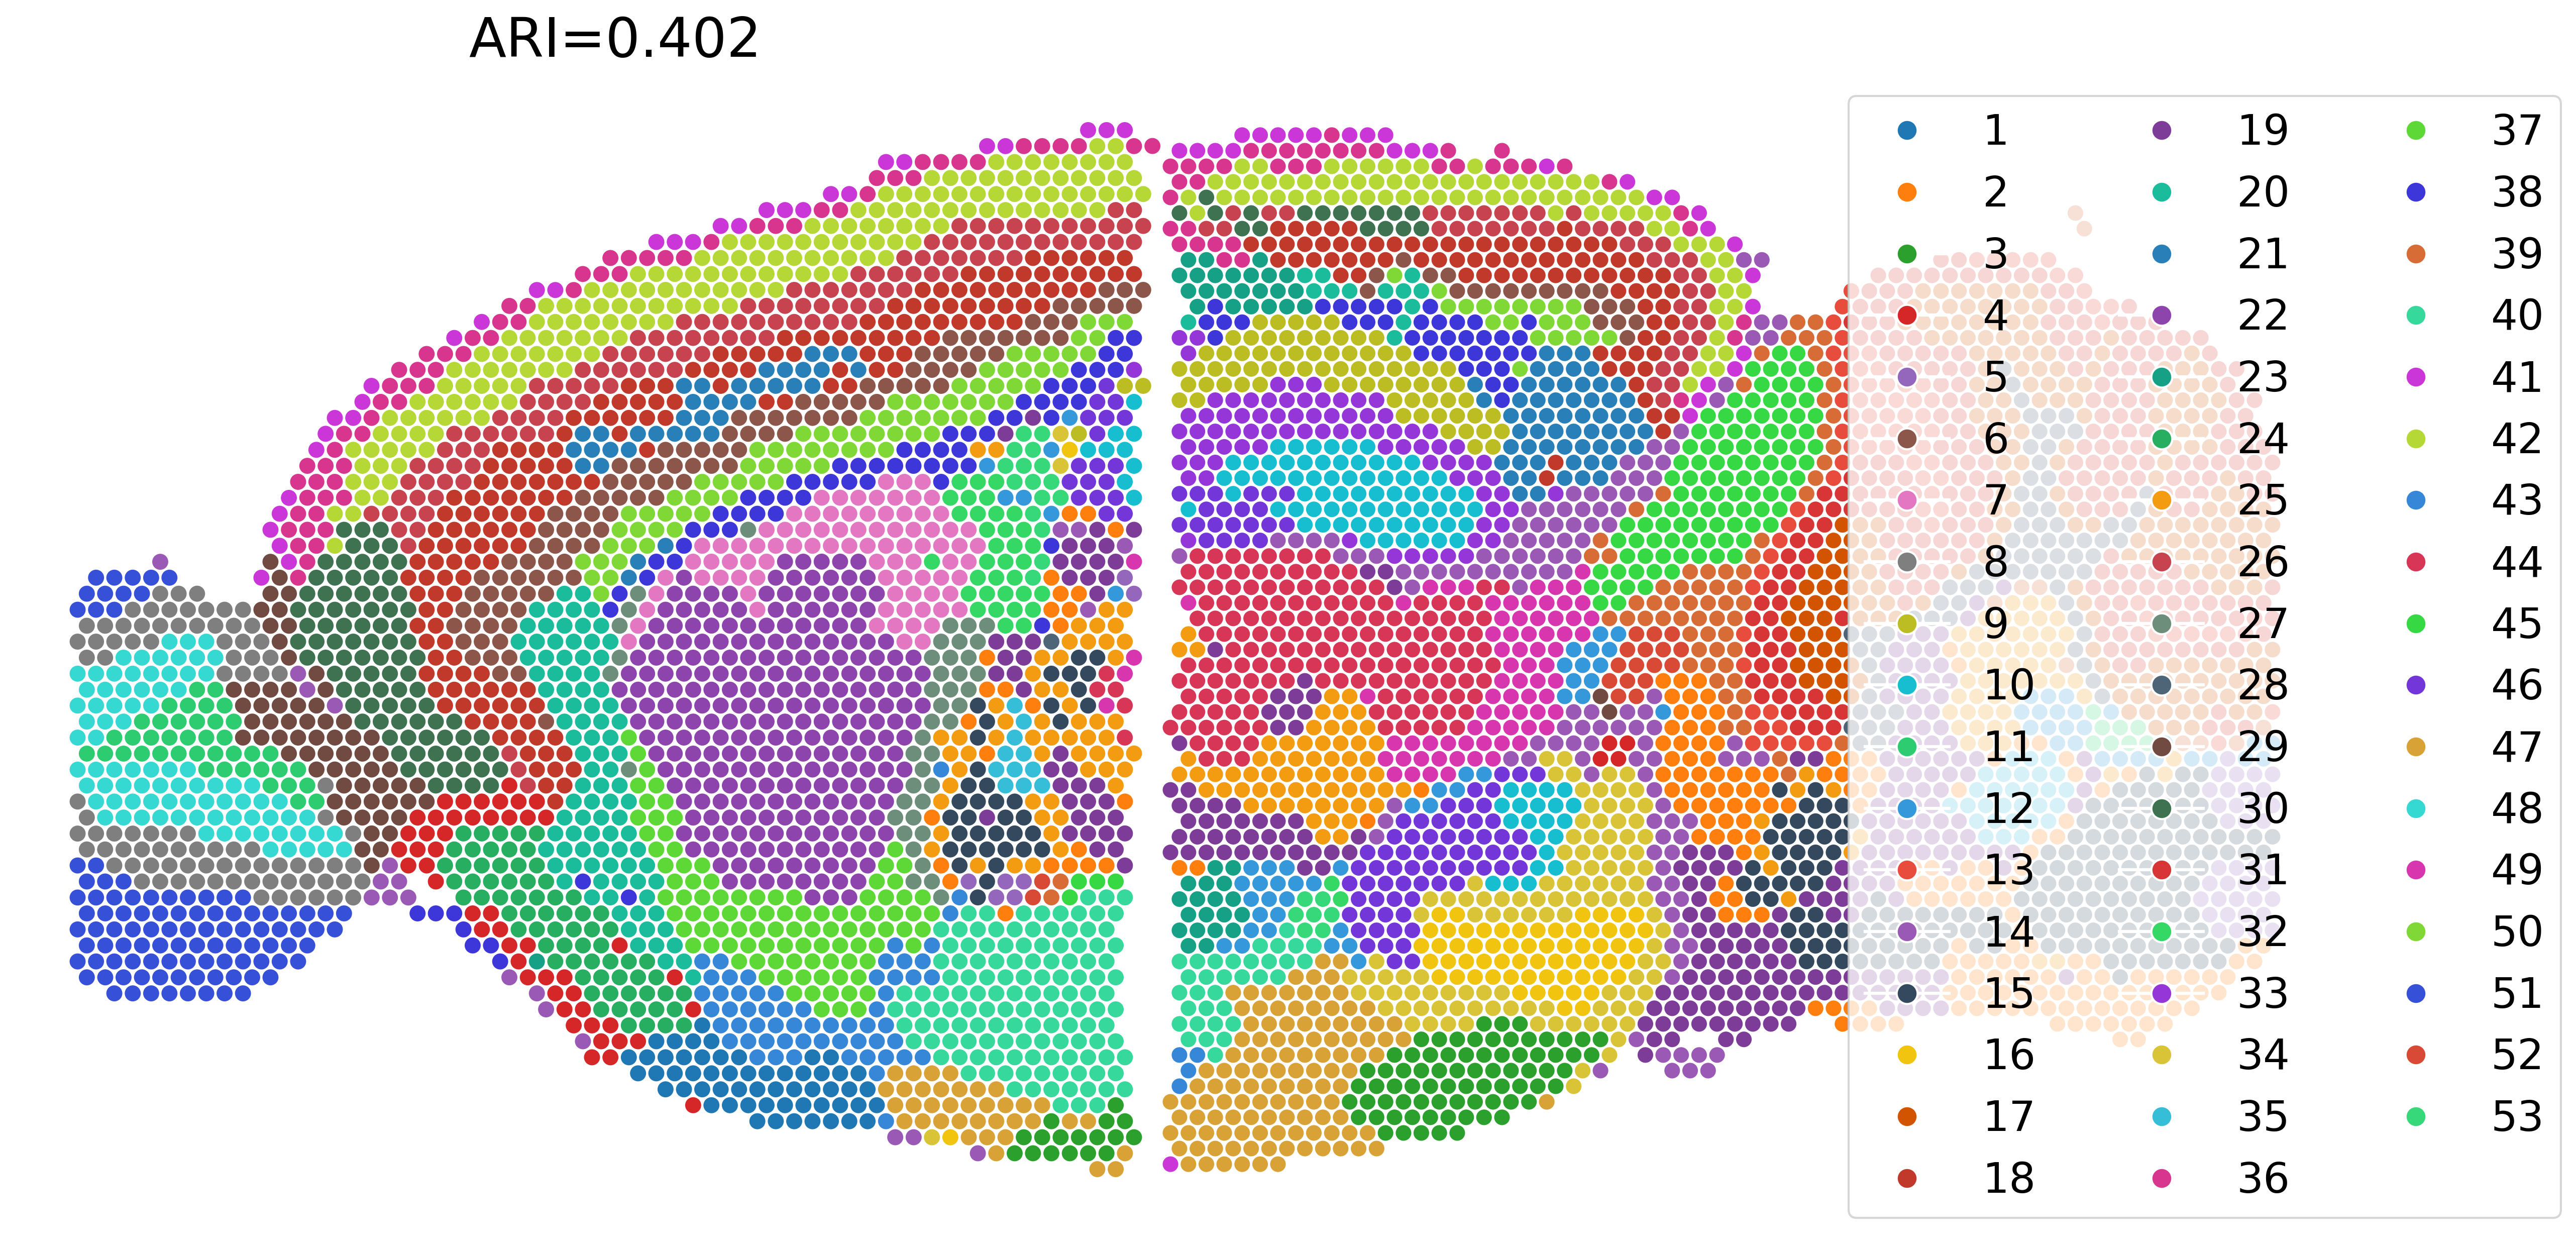

In [7]:
exp_fig_dir = "./temp"
if not os.path.exists(os.path.join(exp_fig_dir, dataset_name+'_'.join(section_ids))):
    os.makedirs(os.path.join(exp_fig_dir, dataset_name+'_'.join(section_ids)))

exp_fig_dir = os.path.join(exp_fig_dir, dataset_name+'_'.join(section_ids))

ari_ = visualization_umap_spatial(ad_temp=ad_concat_2, section_ids=section_ids, exp_fig_dir=exp_fig_dir, dataset_name=dataset_name, num_iter="0", identifier="stage2", num_class=args.num_class, use_key="MG_triplet")
# ari_2.append(ari_[1])
print(section_ids[0], ', ARI = %01.3f' % ari_[0])
print(section_ids[1], ', ARI = %01.3f' % ari_[1])